#Desafio 5 - Equipe 2
##Otimização da predição de casos de diabetes utilizando os dados do dataset Pima Indian Diabetes, com aplicação do Spark em ambiente distribuído e diferentes classificadores da biblioteca MLlib

###Equipe 2 :
             - Filipi Antunes
             - Fernando Oliveira
             - Karla Aleluia
             - Ricardo Gomes

##Considerações iniciais

###O diabetes é um tipo de doença metabólica que se forma por falta de insulina devido ao mau funcionamento do pâncreas. O diabetes pode levar uma pessoa à destruição patológica das células beta pancreáticas, coma, disfunção cardiovascular, insuficiência renal e retinal, insuficiência articular, disfunção sexual, efeitos patogênicos na imunidade, perda de peso e doenças vasculares periféricas.

###Assim, para a detecção precoce de diabetes, uma estrutura robusta foi proposta utilizando Spark em ambiente distribuído e utilização de diferentes classificadores de Machine Learning da biblioteca MLlib: Regressão Logística, Árvores de Decisão, Floresta Aleatória e XGBoost. 

###Para avaliar o desempenho dos diferentes modelos foi utilizado a correspondente área sob a curva ROC (AUC) como a métrica de desempenho. Usando a técnica de validação cruzada e parametrização de modelos, o AUC é então maximizado durante o ajuste dos hiperparâmetros para cada modelo.

###Todos os experimentos foram conduzidos sobre a base de dados da população de índias Pima, disponível publicamente na internet, com 768 pacientes, onde há 268 pacientes diabéticas (variável alvo 'class' = 1) e 500 pacientes não diabéticas (variável alvo 'class' = 0) e com oito atributos distintos conforme descrição abaixo:
- n_pregnant: quantidade de gravidez
- plasma_glucose_concentration: concentração de glicose no sangue
- blood_pressure: pressão sanguínea (mm Hg)
- triceps_skinfold_thickness: espessura da pele do tríceps(mm)
- 2hours_serum_insulin: insulina(microU/ml)
- body_mass_index: índice de massa corpórea (Peso em kg/(altura em polegadas)**2)
- diabtes_pedigree_function: função calculada considerando o percentual de parentes que desenvolveram ou não diabetes
- age: idade(anos)

###Quatro experimentos foram realizados em busca da melhor performance dos modelos:
- Lab 1 = Utilização dos dados originais sem processamento
- Lab 2 = Utilização dos dados originais sem processamento e a seleção das principais features
- Lab 3 = Substituição dos valores zerados de determinados atributos
- Lab 4  = Substituição dos valores zerados de determinados atributos e a seleção das principais features

###Este notebook apresenta o desenvolvimento do Lab 4 onde conseguimos os melhores desempenhos de modo geral, alcançando um valor máximo de AUC de 0,9247 utilizando o classificador Regressão Logística e sem otimização dos parâmetros.


## Instalação do Java e pySpark

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.3MB 66kB/s 
     |████████████████████████████████| 204kB 37.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=aea8ba2a8d2b394a859640e7a380044cc59899fca3b86382d7ceb5e0dd9d3b08
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this 

##Bibliotecas





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

##Sessão Spark

In [ ]:
# criando a sessão Spark
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

##Análise exploratória básica

In [ ]:
#leitura da base
df = spark.read.csv("/content/pima_indian_diabetes_des5.csv", header=True, inferSchema=True)

In [ ]:
#dimensão da base
print((df.count(), len(df.columns)))

(768, 9)


In [ ]:
#schema da base
df.printSchema()


root
 |-- n_pregnant: integer (nullable = true)
 |-- plasma_glucose_concentration: integer (nullable = true)
 |-- blood_pressure: integer (nullable = true)
 |-- triceps_skinfold_thickness: integer (nullable = true)
 |-- 2hours_serum_insulin: integer (nullable = true)
 |-- body_mass_index: double (nullable = true)
 |-- diabtes_pedigree_function: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- class: integer (nullable = true)



In [ ]:
#primeiras 10 linhas da base
df.show(10)


+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+---+-----+
|n_pregnant|plasma_glucose_concentration|blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|body_mass_index|diabtes_pedigree_function|age|class|
+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+---+-----+
|         6|                         148|            72|                        35|                   0|           33.6|                    0.627| 50|    1|
|         1|                          85|            66|                        29|                   0|           26.6|                    0.351| 31|    0|
|         8|                         183|            64|                         0|                   0|           23.3|                    0.672| 32|    1|
|         1|                          89|            66|  

###Balanceamento da base

In [ ]:
#verificação do balanceamento das classes do dataset
df.groupby('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|    1|  268|
|    0|  500|
+-----+-----+



Observações:
- A base tem desbalanceamnto entre as classes positivas e negativas, onde a classe positiva corresponde a cerca de 34,89%  do total.
- Para balanceamento das classes pode-se utilizar métodos de oversampling, undersampling ou combinação dos dois métodos.
Como temos um conjunto de dados
relativamente pequeno, aplicar undersampling na classe dominante traz o
risco de se descartar informações úteis. Nesse caso, em vez de aplicar
downsampling no caso dominante, o mais recomendável seria aplicar oversampling
na classe minoritária.
-Outra estratégia para se atingir um efeito semelhante seria  ponderar os dados. Muitos algoritmos de classificação assumem uma parametrização de pesos que permite
ponderar os dados acima/abaixo.
- Optamos em não realizar o balanceamento de classes e quando possivel fazer a ponderação no próprio modelo.

###Estatística descritiva da base

In [ ]:
# resumo da estatística descritiva da base
df.describe().show()

+-------+------------------+----------------------------+------------------+--------------------------+--------------------+------------------+-------------------------+------------------+------------------+
|summary|        n_pregnant|plasma_glucose_concentration|    blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|   body_mass_index|diabtes_pedigree_function|               age|             class|
+-------+------------------+----------------------------+------------------+--------------------------+--------------------+------------------+-------------------------+------------------+------------------+
|  count|               768|                         768|               768|                       768|                 768|               768|                      768|               768|               768|
|   mean|3.8450520833333335|                120.89453125|       69.10546875|        20.536458333333332|   79.79947916666667|31.992578124999977|       0.4718763020833327

Observações:
-  observa-se que  existem vários atributos com valores zerados(min=0).
- á exceção do atributo n_pregnant, a existência de valores zerados verificada nos demais atributos sugere falha no preenchimento dos dados, considerando que por tratar-se de medidas biométricas e informações laboratoriais, é improvável a existência de valores reais zerados para estes atributos. 


###Gráfico de distribuição e dispersão dos atributos por classes

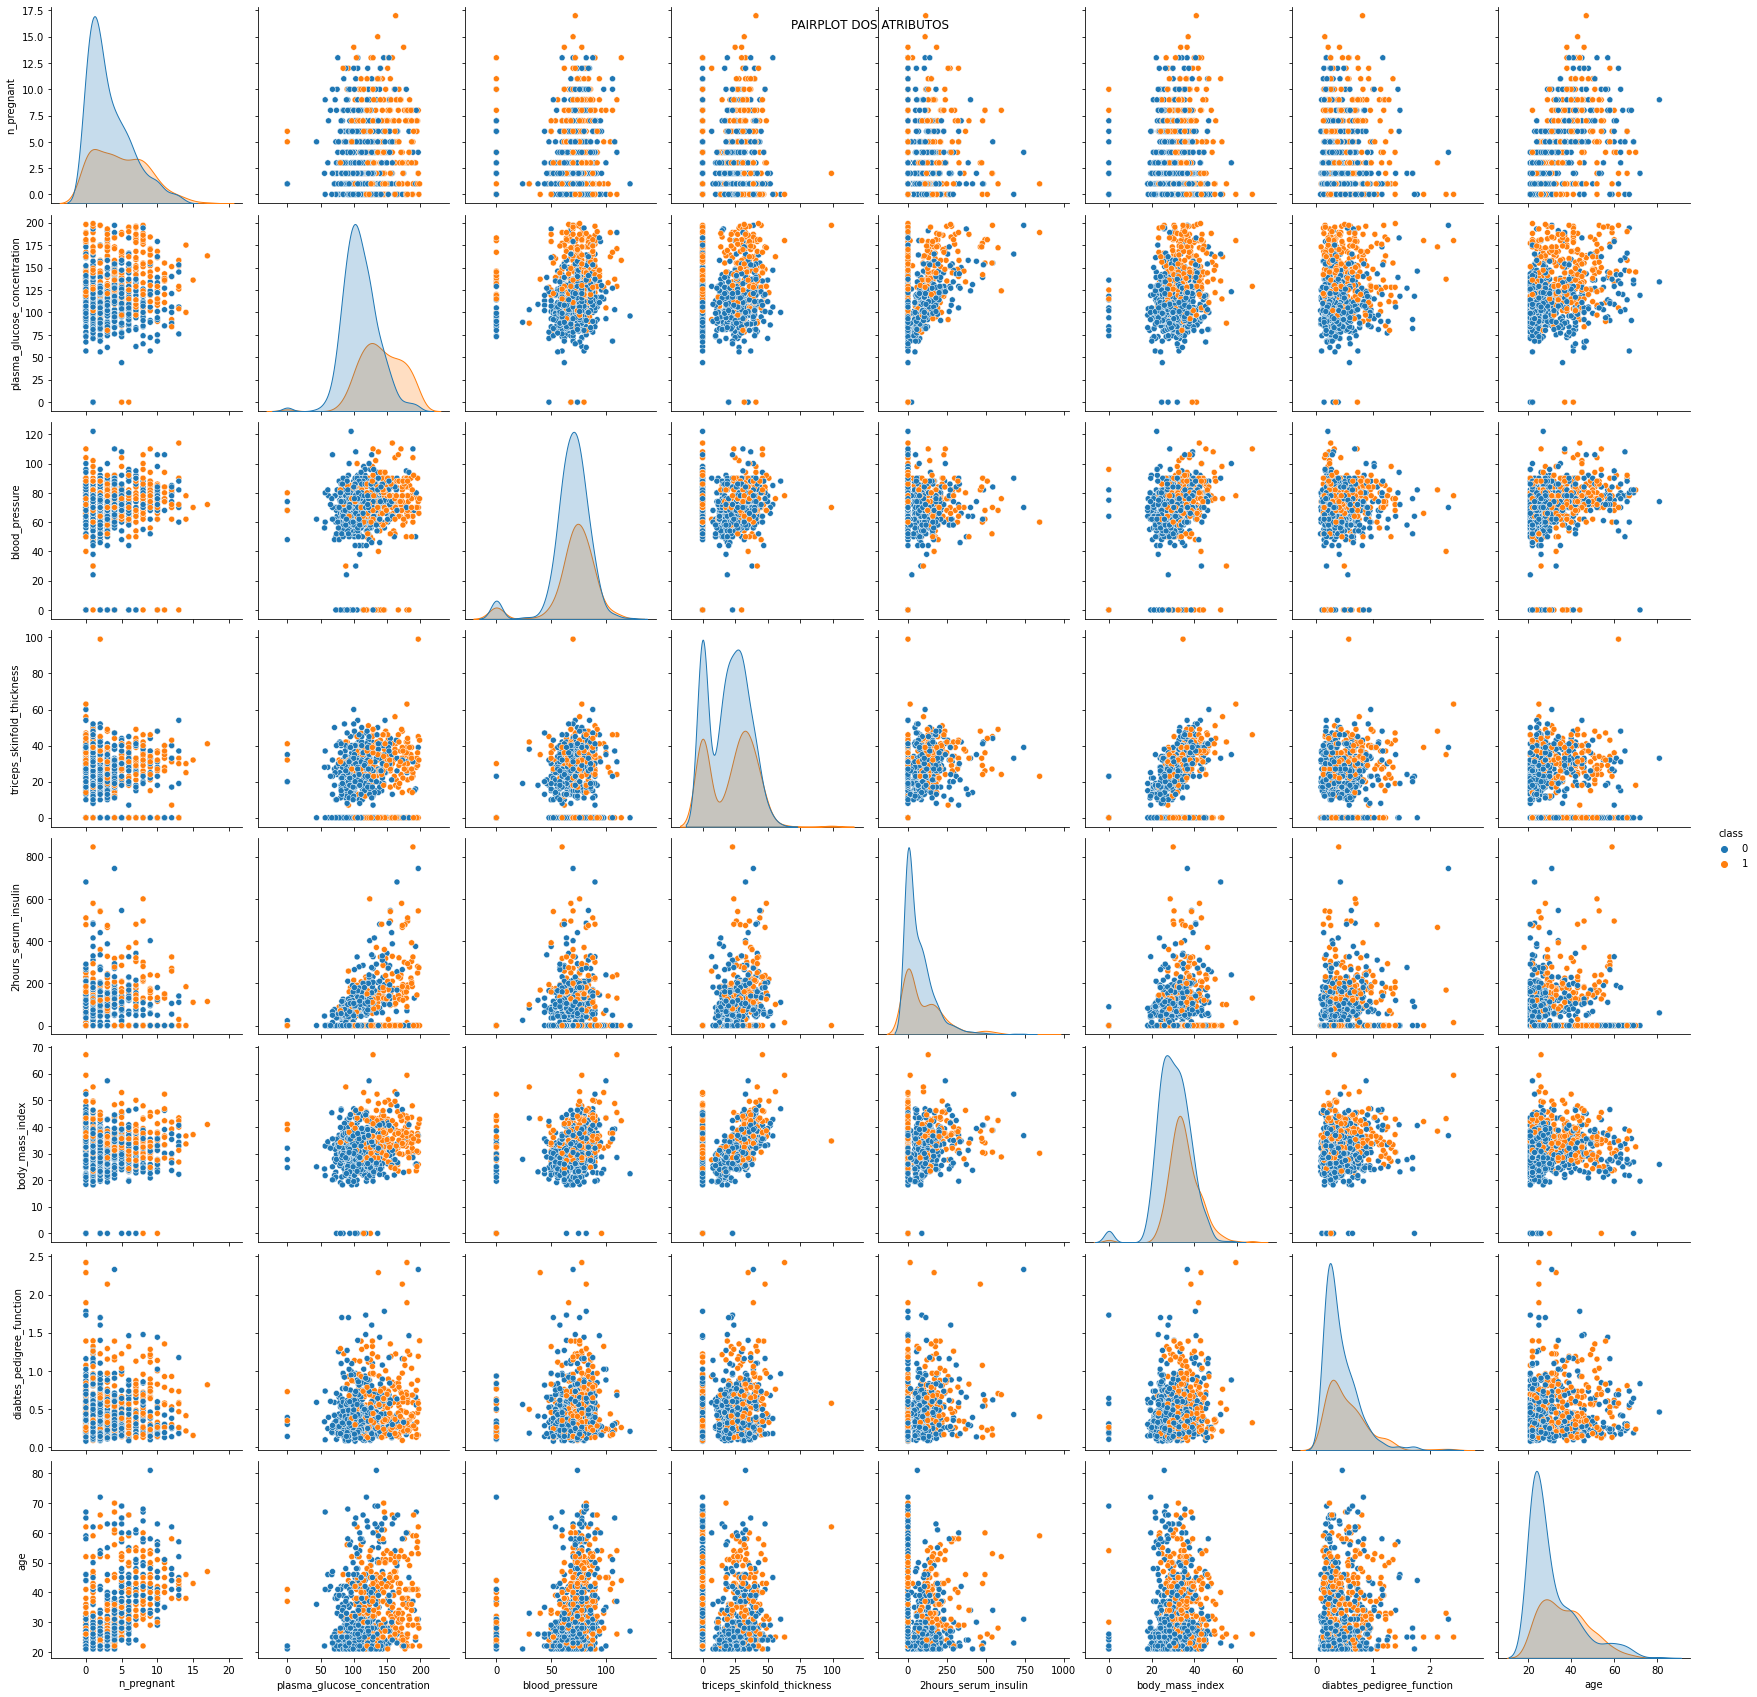

In [ ]:
# conversão do dataset para pandas e plot
import seaborn as sns
df_pd = df.toPandas()
pair_plot =sns.pairplot(data=df_pd,            
                          height=3,
                          hue='class',  
                          diag_kind='kde')
pair_plot.fig.suptitle("PAIRPLOT DOS ATRIBUTOS")
plt.show()

Observações:
- A diagonal mostra a distribuição do conjunto de dados com os gráficos de densidade de ambas as classes(azul= não-diabéticas e laranja= diabéticas).

- Os gráficos de dispersão mostram a relação entre os pares de atributos onde verifica-se que nenhum atributo é capaz de distinguir claramente as duas classes.

###Verificação de outliers

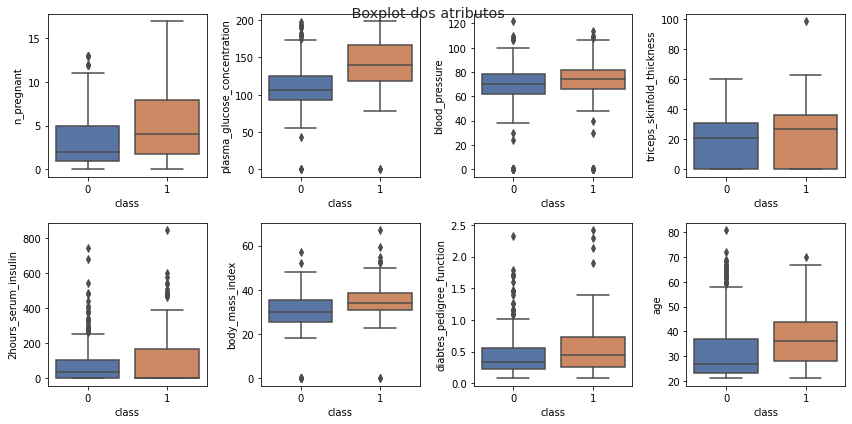

In [ ]:
# Verificação de outliers
fig, ax = plt.subplots(2,4, figsize=(12,6))          
  # #set numbers of rows and columns of subplot and figure size 
sns.set()
sns.boxplot(x = df_pd['class'], y=df_pd['n_pregnant'],                    ax=ax[0,0]) 
sns.boxplot(x = df_pd['class'], y=df_pd['plasma_glucose_concentration'],  ax=ax[0,1])  
sns.boxplot(x = df_pd['class'], y=df_pd['blood_pressure'],                ax=ax[0,2])   
sns.boxplot(x = df_pd['class'], y=df_pd['triceps_skinfold_thickness'],    ax=ax[0,3])  
sns.boxplot(x = df_pd['class'], y=df_pd['2hours_serum_insulin'],          ax=ax[1,0]) 
sns.boxplot(x = df_pd['class'], y=df_pd['body_mass_index'],               ax=ax[1,1])   
sns.boxplot(x = df_pd['class'], y=df_pd['diabtes_pedigree_function'],     ax=ax[1,2])   
sns.boxplot(x = df_pd['class'], y=df_pd['age'],                           ax=ax[1,3])    
fig.suptitle(" Boxplot dos atributos")
fig.tight_layout()

Observações:
- O boxplot do conjunto de dados mostra a presença de outliers nos atributos distribuidos em ambas as classes(azul= não-diabéticas e laranja= diabéticas).

- O atributo 'triceps_skinfold_thickness' apresentou a menor quantidade de outliers.

- O atributo '2hours_serum_insulin' apresentou mediana igual a zero para a classe 1.

###Correlação entre variáveis

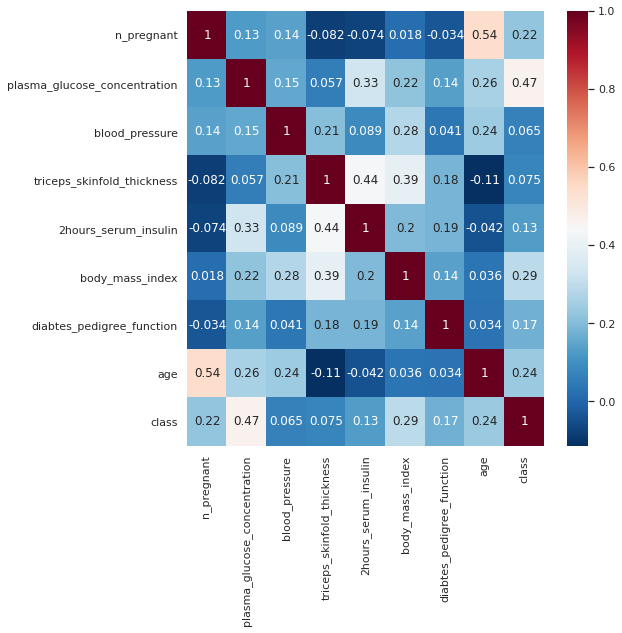

In [ ]:
#heatmap da correlação das variáveis numéricas
plt.figure(figsize=(8,8))
sns.heatmap(df_pd.corr(), cmap='RdBu_r', annot=True)
plt.show()

Observações:
- O gráfico de correlação mostra que todos os atributoas têm baixa correlação com o atributo alvo.

- O atributo 'plasma_glucose_concentration' apresentou a maior correlação positiva com o atributo alvo e
'blood_pressure' e 'triceps_skinfold_thickness' aparentemente não tem correlação com o atributo alvo.

-O atributo 'n_pregnant' tem a maior correlação do dataset relacionada ao atributo 'age'.

##Pré-processamento

###Outliers
A presença de outiliers pode ser resultado de dados ruins e deveriam ser melhor analisados e tratados. Todavia devido ao tamanho reduzido da base, optamos em não retirá-los do processamento.

###Substituição dos valores zerados
Consideramos que a presença de dados zerados no dataset são decorrentes de falhas na coleta ou no preenchimento das informações e optamos em  substituir os valores dos atributos(exceto 'n_pregnant') utilizando como substitutos os valores das medianas dos atributos, tendo em vista que a mediana é uma estimativa mais robusta  na presença de outliers.


cálculo das medianas dos atributos com valores zerados com e sem separação de classes (exceto "n_pregnant")

In [ ]:
#cálculo das medianas do dataset geral
median_plasma_glucose_concentration = df.approxQuantile('plasma_glucose_concentration',[0.5], 0)
median_blood_pressure = df.approxQuantile('blood_pressure',[0.5], 0)
median_triceps_skinfold_thickness = df.approxQuantile('triceps_skinfold_thickness',[0.5], 0)
median_2hours_serum_insulin = df.approxQuantile('2hours_serum_insulin',[0.5], 0)
median_body_mass_index = df.approxQuantile('body_mass_index',[0.5], 0)
print(median_plasma_glucose_concentration,median_blood_pressure,median_triceps_skinfold_thickness ,\
      median_2hours_serum_insulin,median_body_mass_index )

[117.0] [72.0] [23.0] [29.0] [32.0]


In [ ]:
#dataset somente com classes negativas
df_negative= df.select(['n_pregnant','plasma_glucose_concentration','blood_pressure','triceps_skinfold_thickness','2hours_serum_insulin','body_mass_index','diabtes_pedigree_function','age','class'])\
.filter(df['class'] == 0)

In [ ]:
df_negative.describe().show()

+-------+-----------------+----------------------------+------------------+--------------------------+--------------------+-----------------+-------------------------+------------------+-----+
|summary|       n_pregnant|plasma_glucose_concentration|    blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|  body_mass_index|diabtes_pedigree_function|               age|class|
+-------+-----------------+----------------------------+------------------+--------------------------+--------------------+-----------------+-------------------------+------------------+-----+
|  count|              500|                         500|               500|                       500|                 500|              500|                      500|               500|  500|
|   mean|            3.298|                      109.98|            68.184|                    19.664|              68.792|30.30419999999996|      0.42973400000000017|             31.19|  0.0|
| stddev|3.017184582621889|        

In [ ]:
#calculo das medianas dos atributos das classes negativas
median_plasma_glucose_concentration_n = df_negative.approxQuantile('plasma_glucose_concentration',[0.5], 0)
median_blood_pressure_n= df_negative.approxQuantile('blood_pressure',[0.5], 0)
median_triceps_skinfold_thickness_n = df_negative.approxQuantile('triceps_skinfold_thickness',[0.5], 0)
median_2hours_serum_insulin_n = df_negative.approxQuantile('2hours_serum_insulin',[0.5],0)
median_body_mass_index_n = df_negative.approxQuantile('body_mass_index',[0.5], 0)
print(median_plasma_glucose_concentration_n,median_blood_pressure_n,median_triceps_skinfold_thickness_n ,\
      median_2hours_serum_insulin_n,median_body_mass_index_n )

[107.0] [70.0] [21.0] [38.0] [30.0]


In [ ]:
#dataset somente com classes positivas
df_positive=df.select(['n_pregnant','plasma_glucose_concentration','blood_pressure','triceps_skinfold_thickness','2hours_serum_insulin','body_mass_index','diabtes_pedigree_function','age','class'])\
.filter(df['class'] == 1)


In [ ]:
df_positive.describe().show()

+-------+------------------+----------------------------+------------------+--------------------------+--------------------+-----------------+-------------------------+------------------+-----+
|summary|        n_pregnant|plasma_glucose_concentration|    blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|  body_mass_index|diabtes_pedigree_function|               age|class|
+-------+------------------+----------------------------+------------------+--------------------------+--------------------+-----------------+-------------------------+------------------+-----+
|  count|               268|                         268|               268|                       268|                 268|              268|                      268|               268|  268|
|   mean| 4.865671641791045|          141.25746268656715| 70.82462686567165|         22.16417910447761|  100.33582089552239|35.14253731343278|                   0.5505| 37.06716417910448|  1.0|
| stddev|3.7412390440415546|  

In [ ]:
#calculo das medianas dos atributos das classes positivas
median_plasma_glucose_concentration_p= df_positive.approxQuantile('plasma_glucose_concentration',[0.5], 0)
median_blood_pressure_p= df_positive.approxQuantile('blood_pressure',[0.5], 0)
median_triceps_skinfold_thickness_p= df_positive.approxQuantile('triceps_skinfold_thickness',[0.5], 0)
median_2hours_serum_insulin_p= df_positive.approxQuantile('2hours_serum_insulin',[0.5], 0)
median_body_mass_index_p= df_positive.approxQuantile('body_mass_index',[0.5], 0)
print(median_plasma_glucose_concentration_p,median_blood_pressure_p,median_triceps_skinfold_thickness_p ,\
      median_2hours_serum_insulin_p,median_body_mass_index_p )

[140.0] [74.0] [27.0] [0.0] [34.2]


A mediana do atributo "2hours_serum_insulin" quando a classe é positiva tem valor zero, visto que existem 138 valores zerados e 130 valores diferentes de zero(ver abaixo).

In [ ]:
#verificação distribuição atributo "2hours_serum_insulin" com classe positiva para valores iguais e diferentes de zero
df_positive.select(["2hours_serum_insulin"]).filter(df_positive["2hours_serum_insulin"]==0).count(),\
df_positive.select(["2hours_serum_insulin"]).filter(df_positive["2hours_serum_insulin"]!=0).count()

(138, 130)

In [ ]:
#comparação das medianas entre dataset inteiro e datasets divididos por classes negativas e positivas respectivamente
print(median_plasma_glucose_concentration,median_blood_pressure,median_triceps_skinfold_thickness ,\
      median_2hours_serum_insulin,median_body_mass_index )
print(median_plasma_glucose_concentration_n,median_blood_pressure_n,median_triceps_skinfold_thickness_n ,\
      median_2hours_serum_insulin_n,median_body_mass_index_n )
print(median_plasma_glucose_concentration_p,median_blood_pressure_p,median_triceps_skinfold_thickness_p ,\
      median_2hours_serum_insulin_p,median_body_mass_index_p )

[117.0] [72.0] [23.0] [29.0] [32.0]
[107.0] [70.0] [21.0] [38.0] [30.0]
[140.0] [74.0] [27.0] [0.0] [34.2]


Devido a mediana do atributo "2hours_serum_insulin" ser igual a zero na classe positiva, utilizaremos para substituição dos dados zerados os valores calculados das medianas do dataset sem separação das classes.

Criação do novo dataset sem valores zerados para os atributos selecionados

In [ ]:
df1=df.withColumn("plasma_glucose_concentration", \
              when(df["plasma_glucose_concentration"] == 0, 117.0).otherwise(df["plasma_glucose_concentration"]))

In [ ]:
df2= df1.withColumn('blood_pressure', \
              when(df1['blood_pressure'] == 0, 72.0).otherwise(df1['blood_pressure']))

In [ ]:
df3= df2.withColumn('triceps_skinfold_thickness', \
              when(df2['triceps_skinfold_thickness'] == 0, 23.0).otherwise(df1['triceps_skinfold_thickness']))

In [ ]:
df4= df3.withColumn('2hours_serum_insulin', \
              when(df3['2hours_serum_insulin'] == 0, 29.0).otherwise(df3['2hours_serum_insulin']))

In [ ]:
df5= df4.withColumn('body_mass_index', \
              when(df4['body_mass_index'] == 0, 32.0).otherwise(df4['body_mass_index']))

In [ ]:
#comparação entre dataset final sem valores nulos e o dataset original
df5.describe().show()


+-------+------------------+----------------------------+------------------+--------------------------+--------------------+-----------------+-------------------------+------------------+------------------+
|summary|        n_pregnant|plasma_glucose_concentration|    blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|  body_mass_index|diabtes_pedigree_function|               age|             class|
+-------+------------------+----------------------------+------------------+--------------------------+--------------------+-----------------+-------------------------+------------------+------------------+
|  count|               768|                         768|               768|                       768|                 768|              768|                      768|               768|               768|
|   mean|3.8450520833333335|                   121.65625|       72.38671875|        27.334635416666668|           93.921875|32.45091145833331|       0.4718763020833327|33.2

In [ ]:
df.describe().show()

+-------+------------------+----------------------------+------------------+--------------------------+--------------------+------------------+-------------------------+------------------+------------------+
|summary|        n_pregnant|plasma_glucose_concentration|    blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|   body_mass_index|diabtes_pedigree_function|               age|             class|
+-------+------------------+----------------------------+------------------+--------------------------+--------------------+------------------+-------------------------+------------------+------------------+
|  count|               768|                         768|               768|                       768|                 768|               768|                      768|               768|               768|
|   mean|3.8450520833333335|                120.89453125|       69.10546875|        20.536458333333332|   79.79947916666667|31.992578124999977|       0.4718763020833327

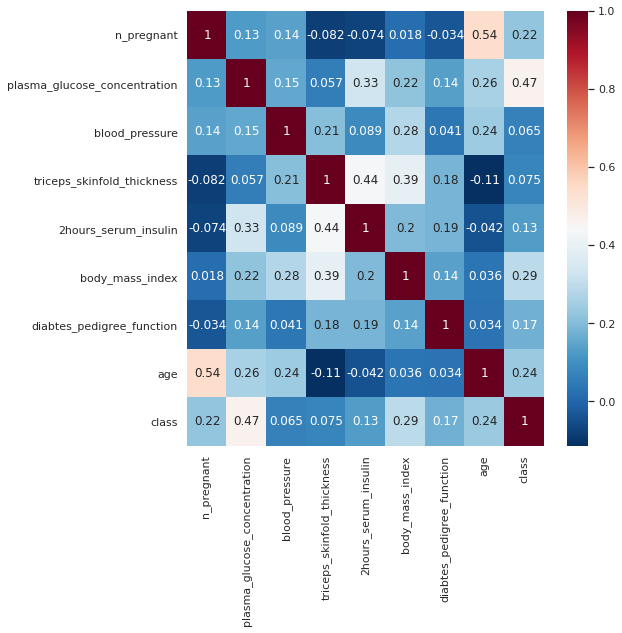

In [ ]:
#heatmap da correlação das variáveis do datset final 
plt.figure(figsize=(8,8))
sns.heatmap(df_pd.corr(), cmap='RdBu_r', annot=True)
plt.show()

Observações:

- O atributo 'plasma_glucose_concentration' apresentou novamente a maior correlação positiva com o atributo alvo.
- 'blood_pressure' e 'triceps_skinfold_thickness' apresentaram expressivo aumento de suas correlações com o atributo alvo em relação ao dataset original.
- 'n_pregnant' versus 'age' e 'body_mass_index' versus 'triceps_skinfold_thickness' tem correlações razoáveis entre si.

### Index labels e features

In [ ]:
df5.columns

['n_pregnant',
 'plasma_glucose_concentration',
 'blood_pressure',
 'triceps_skinfold_thickness',
 '2hours_serum_insulin',
 'body_mass_index',
 'diabtes_pedigree_function',
 'age',
 'class']

In [ ]:
df=df5

In [ ]:
df.describe().show()

+-------+------------------+----------------------------+------------------+--------------------------+--------------------+-----------------+-------------------------+------------------+------------------+
|summary|        n_pregnant|plasma_glucose_concentration|    blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|  body_mass_index|diabtes_pedigree_function|               age|             class|
+-------+------------------+----------------------------+------------------+--------------------------+--------------------+-----------------+-------------------------+------------------+------------------+
|  count|               768|                         768|               768|                       768|                 768|              768|                      768|               768|               768|
|   mean|3.8450520833333335|                   121.65625|       72.38671875|        27.334635416666668|           93.921875|32.45091145833331|       0.4718763020833327|33.2

In [ ]:
for col in df.columns:
    df= df.withColumn(col, df[col].cast('float'))

In [ ]:
df.printSchema()

root
 |-- n_pregnant: float (nullable = true)
 |-- plasma_glucose_concentration: float (nullable = true)
 |-- blood_pressure: float (nullable = true)
 |-- triceps_skinfold_thickness: float (nullable = true)
 |-- 2hours_serum_insulin: float (nullable = true)
 |-- body_mass_index: float (nullable = true)
 |-- diabtes_pedigree_function: float (nullable = true)
 |-- age: float (nullable = true)
 |-- class: float (nullable = true)



In [ ]:
#Index labels e features
stages = []

label_stringIdx = StringIndexer(inputCol = 'class', outputCol = 'label')
stages += [label_stringIdx]
assemblerInputs = ['n_pregnant',
 'plasma_glucose_concentration',
 'blood_pressure',
 'triceps_skinfold_thickness',
 '2hours_serum_insulin',
 'body_mass_index',
 'diabtes_pedigree_function',
 'age']

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
cols = df.columns

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df= pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- n_pregnant: float (nullable = true)
 |-- plasma_glucose_concentration: float (nullable = true)
 |-- blood_pressure: float (nullable = true)
 |-- triceps_skinfold_thickness: float (nullable = true)
 |-- 2hours_serum_insulin: float (nullable = true)
 |-- body_mass_index: float (nullable = true)
 |-- diabtes_pedigree_function: float (nullable = true)
 |-- age: float (nullable = true)
 |-- class: float (nullable = true)



###Seleção de features

Para selecionar features utilizamos o método UnivariateFeatureSelector para escolher as top 6
(https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.UnivariateFeatureSelector.html)

In [ ]:
#seleção das 6 principais features e criação de novo dataset com adição da coluna 'selectedFeatures'
from pyspark.ml.feature import UnivariateFeatureSelector
selector = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures",
                                         labelCol="label", selectionMode="numTopFeatures")
selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(6)

result = selector.fit(df).transform(df)

print("UnivariateFeatureSelector output with top %d features selected using f_classif"
          % selector.getSelectionThreshold())
#result.show(50)
result.show(10)


UnivariateFeatureSelector output with top 6 features selected using f_classif
+-----+--------------------+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+----+-----+--------------------+
|label|            features|n_pregnant|plasma_glucose_concentration|blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|body_mass_index|diabtes_pedigree_function| age|class|    selectedFeatures|
+-----+--------------------+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+----+-----+--------------------+
|  1.0|[6.0,148.0,72.0,3...|       6.0|                       148.0|          72.0|                      35.0|                29.0|           33.6|                    0.627|50.0|  1.0|[6.0,148.0,35.0,3...|
|  0.0|[1.0,85.0,66.0,29...|       1.0|                        85.0|          66.0|               

###Separação treino/teste

In [ ]:
#dataset com as 6 principais features selecionadas
result.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- n_pregnant: float (nullable = true)
 |-- plasma_glucose_concentration: float (nullable = true)
 |-- blood_pressure: float (nullable = true)
 |-- triceps_skinfold_thickness: float (nullable = true)
 |-- 2hours_serum_insulin: float (nullable = true)
 |-- body_mass_index: float (nullable = true)
 |-- diabtes_pedigree_function: float (nullable = true)
 |-- age: float (nullable = true)
 |-- class: float (nullable = true)
 |-- selectedFeatures: vector (nullable = true)



In [ ]:
# Preparando os modelos
train, test = result.randomSplit([0.95, 0.05], seed = 2019)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 717
Test Dataset Count: 51


In [ ]:
#verificação balanceamento treino/teste
train.groupby('class').count().show(),\
test.groupby('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|  1.0|  246|
|  0.0|  471|
+-----+-----+

+-----+-----+
|class|count|
+-----+-----+
|  1.0|   22|
|  0.0|   29|
+-----+-----+



(None, None)

Observações:
- A base de teste tem desbalanceamnto entre as classes positivas e negativas, onde a classe positiva corresponde a cerca de 34,30%  do total refletindo a condição de desbalanceamneto da base original.

##Testando os modelos

###Regressão Logística

In [ ]:
from pyspark.ml.classification import  LogisticRegression
lr = LogisticRegression(featuresCol = 'selectedFeatures', labelCol = 'label')
#lr = LogisticRegression(featuresCol = 'selectedFeatures', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

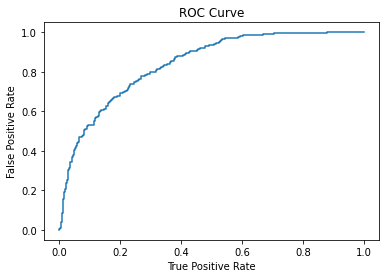

Training set areaUnderROC: 0.8399271572333552


In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
summary = lrModel.summary
print (summary.areaUnderROC)
#summary.roc.show()
#summary.pr.show()

0.8399271572333552


In [ ]:
#summary.objectiveHistory

In [ ]:
#print (lrModel.coefficients)
#print (lrModel.intercept)

In [ ]:
# Fazendo predições usando nossa base de teste.
predictions = lrModel.transform(test)
predictions.select('n_pregnant',
 'plasma_glucose_concentration',
 'blood_pressure',
 'triceps_skinfold_thickness',
 '2hours_serum_insulin',
 'body_mass_index',
 'diabtes_pedigree_function',
 'age', "label", "rawPrediction", "prediction", "probability").show(10)

+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+----+-----+--------------------+----------+--------------------+
|n_pregnant|plasma_glucose_concentration|blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|body_mass_index|diabtes_pedigree_function| age|label|       rawPrediction|prediction|         probability|
+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+----+-----+--------------------+----------+--------------------+
|       0.0|                        99.0|          72.0|                      23.0|                29.0|           25.0|                    0.253|22.0|  0.0|[3.05265613387914...|       0.0|[0.95489706097499...|
|       0.0|                       102.0|          86.0|                      17.0|               105.0|           29.3|                    0.695|27.0|  0.0

In [ ]:
# Avaliando modelos
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9247648902821316


In [ ]:
#evaluator.getMetricName()

In [ ]:
print("O modelo foi treinado usando os seguintes parametros: ")
print(lrModel.explainParams())

O modelo foi treinado usando os seguintes parametros: 
aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: selectedFeatures)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on 

####Descrição dos Hiperparametros
fonte: Spark Guide Definitive, Bill Chambers and Matei Zaharia, O´Reilly

- family:
Pode ser multinomial (dois ou mais rótulos distintos; classificação multiclasse) ou binária (apenas dois rótulos distintos; classificação binária).
- aggregationDepth:  profundidade sugerida maior ou igual a 2.
   Se as dimensões dos atributos ou o número de partições forem grandes,
   este parâmetro pode ser ajustado para um tamanho maior.
   O padrão é 2.

- elasticNetParam:
Um valor de ponto flutuante de 0 a 1. Este parâmetro especifica a combinação de regularização L1 e L2 de acordo com a regularização líquida elástica (que é uma combinação linear das duas). Sua escolha de L1 ou L2 depende muito do seu caso de uso particular, mas a intuição é a seguinte: A regularização L1 (um valor de 1) criará esparsidade no modelo porque certos pesos de recursos se tornarão zero (que são de pouca consequência para o resultado). Por esse motivo, ele pode ser usado como um método simples de seleção de recursos. Por outro lado, a regularização L2 (um valor de 0) não cria esparsidade porque os pesos correspondentes para recursos específicos serão direcionados apenas para zero, mas nunca chegarão completamente a zero. ElasticNet nos dá o melhor dos dois mundos - podemos escolher um valor entre 0 e 1 para especificar uma combinação de regularização L1 e L2. Na maior parte, você deve ajustar isso testando valores diferentes.
- fitIntercept:
Pode ser verdadeiro ou falso. Este hiperparâmetro determina se deve ou não ajustar a interceptação ou o número arbitrário que é adicionado à combinação linear de entradas e pesos do modelo. Normalmente, você desejará ajustar a interceptação se não tivermos normalizado nossos dados de treinamento.
- regParam:
Um valor ≥ 0. que determina quanto peso dar ao termo de regularização na função objetivo. A escolha de um valor aqui será novamente uma função do ruído e da dimensionalidade em nosso conjunto de dados. Em um pipeline, tente uma ampla gama de valores (por exemplo, 0, 0,01, 0,1, 1).
- standardization:
Pode ser verdadeiro ou falso, padronizando ou não as entradas antes de passá-las para o modelo. 
- maxIter:
Número total de iterações sobre os dados antes de parar. Alterando este parâmetro provavelmente
não mudará seus resultados muito, então não deve ser o primeiro parâmetro que você deve tentar ajustar. O padrão é 100.
- tol:
Este valor especifica um limite pelo qual as mudanças nos parâmetros mostram que otimizamos nosso
pesa o suficiente e pode parar de iterar. Ele permite que o algoritmo pare antes das iterações máximas.
O valor padrão é 1.0E-6. Este também não deve ser o primeiro parâmetro que você procura ajustar.
- weightCol:
O nome de uma coluna de peso usada para pesar certas linhas mais do que outras. Isso pode ser um
ferramenta útil se você tiver alguma outra medida de quão importante é um exemplo de treinamento específico
e tem um peso associado a ele. Por exemplo, você pode ter 10.000 exemplos onde
você sabe que alguns rótulos são mais precisos do que outros. Você pode pesar os rótulos que você
sabe que estão corretos mais do que aqueles que você não sabe.
- threshold:
A Double no intervalo de 0 a 1. Este parâmetro é o limite de probabilidade para quando um determinado
classe deve ser prevista. Você pode ajustar este parâmetro de acordo com seus requisitos para
equilíbrio entre falsos positivos e falsos negativos. Por exemplo, se uma previsão errada
seria caro - você pode querer tornar seu limite de previsão muito alto.
- thresholds:
Este parâmetro permite que você especifique uma matriz de valores de limite para cada classe ao usar
classificação multiclasse. Funciona de forma semelhante ao parâmetro de limite único descrito
anteriormente.

####Otimização do modelo

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.elasticNetParam, [0, 0.5, 1])
             .addGrid(lr.maxIter, [5, 10, 100])
             .addGrid(lr.regParam, [0, 0.01, 0.1, 1 ])
             .build())
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8934169278996865

In [ ]:
#parametros escolhidos nesta fase
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='LogisticRegression_2e36c47d9ca1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_2e36c47d9ca1', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='LogisticRegression_2e36c47d9ca1', name='regParam', doc='regularization parameter (>= 0).'): 0.1}


###Arvore de decisão


In [ ]:
#arvore de decisão
from pyspark.ml.classification import DecisionTreeClassifier
#dt = DecisionTreeClassifier(featuresCol = 'selectedFeatures', labelCol = 'label', maxDepth= 10  )
dt = DecisionTreeClassifier(featuresCol = 'selectedFeatures', labelCol = 'label')
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('n_pregnant',
 'plasma_glucose_concentration',
 'blood_pressure',
 'triceps_skinfold_thickness',
 '2hours_serum_insulin',
 'body_mass_index',
 'diabtes_pedigree_function',
 'age', "label", "rawPrediction", "prediction", "probability").show(10)

+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+----+-----+-------------+----------+--------------------+
|n_pregnant|plasma_glucose_concentration|blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|body_mass_index|diabtes_pedigree_function| age|label|rawPrediction|prediction|         probability|
+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+----+-----+-------------+----------+--------------------+
|       0.0|                        99.0|          72.0|                      23.0|                29.0|           25.0|                    0.253|22.0|  0.0|  [148.0,3.0]|       0.0|[0.98013245033112...|
|       0.0|                       102.0|          86.0|                      17.0|               105.0|           29.3|                    0.695|27.0|  0.0|  [148.0,3.0]|       0.0|[0

In [ ]:
# Avaliando modelos
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7092476489028213


In [ ]:
print("O modelo foi treinado usando os seguintes parametros: ")
print(dtModel.explainParams())

O modelo foi treinado usando os seguintes parametros: 
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: selectedFeatures)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by

In [ ]:
print("numNodes = ", dtModel.numNodes)
print("depth = ", dtModel.depth)

numNodes =  49
depth =  5


####Hiperparametros
- maxDepth:
Como estamos treinando uma árvore, pode ser útil especificar uma profundidade máxima para evitar
overfitting para o conjunto de dados (no extremo, cada linha termina como seu próprio nó folha). O padrão é 5.
- maxBins:
Em árvores de decisão, features contínuos são convertidos em features categóricos e maxBins
determina quantas caixas devem ser criadas a partir de features contínuos. Mais caixas dão um
nível mais alto de granularidade. O valor deve ser maior ou igual a 2 e maior ou
igual ao número de categorias em qualquer feature categórico em seu conjunto de dados. O padrão é 32.
- impurity:
Para construir uma “árvore”, você precisa configurar quando o modelo deve se ramificar. Impureza
representa a métrica (ganho de informação) para determinar se o modelo deve ou não ser dividido em
um nó folha particular. Este parâmetro pode ser definido como "entropia" ou "gini" (padrão),
duas métricas de impureza comumente usadas.
- minInfoGain:
Este parâmetro determina o ganho mínimo de informação que pode ser usado para uma divisão.
um valor mais alto pode evitar o sobreajuste. Em grande parte, isso é algo que precisa ser determinado
de testar diferentes variações do modelo de árvore de decisão. O padrão é zero.
- minInstancePerNode:
Este parâmetro determina o número mínimo de instâncias de treinamento que precisam terminar em um
nó particular. Pense nisso como outra maneira de controlar a profundidade máxima. Nós podemos prevenir
overfitting limitando a profundidade ou podemos evitá-lo especificando que, no mínimo, um certo
número de valores de treinamento precisam terminar em um nó folha específico. Se não for atendido, podemos
podar a árvore até que esse requisito seja atendido. Um valor mais alto pode evitar o sobreajuste. O
o padrão é 1, mas pode ser qualquer valor maior que 1.
- checkpointInterval:
O ponto de verificação é uma maneira de salvar o trabalho do modelo durante o treinamento para que os nós
na falha do cluster por algum motivo, você não perde seu trabalho. Um valor de 10 significa o
o modelo será verificado a cada 10 iterações. Defina como -1 para desligar o ponto de verificação. Esta
parâmetro precisa ser definido junto com um checkpointDir (um diretório para o ponto de verificação) e
com useNodeIdCache = true. Consulte a documentação do Spark para obter mais informações sobre
checkpointing.

####Otimização do modelo

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10, 15])
             .addGrid(dt.minInstancesPerNode, [1, 3, 5])
             .addGrid(dt.minInfoGain, [0, 1, 5, 10 ])
             .build())
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.7092476489028213

In [ ]:
#parametros escolhidos nesta fase
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='DecisionTreeClassifier_6ec78a108586', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='DecisionTreeClassifier_6ec78a108586', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 50, Param(parent='DecisionTreeClassifier_6ec78a108586', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0}


###Floresta Aleatória

In [ ]:
#floresta aleatoria
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'selectedFeatures', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('n_pregnant',
 'plasma_glucose_concentration',
 'blood_pressure',
 'triceps_skinfold_thickness',
 '2hours_serum_insulin',
 'body_mass_index',
 'diabtes_pedigree_function',
 'age', "label", "rawPrediction", "prediction", "probability").show(10)

+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+----+-----+--------------------+----------+--------------------+
|n_pregnant|plasma_glucose_concentration|blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|body_mass_index|diabtes_pedigree_function| age|label|       rawPrediction|prediction|         probability|
+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+----+-----+--------------------+----------+--------------------+
|       0.0|                        99.0|          72.0|                      23.0|                29.0|           25.0|                    0.253|22.0|  0.0|[19.3269801752966...|       0.0|[0.96634900876483...|
|       0.0|                       102.0|          86.0|                      17.0|               105.0|           29.3|                    0.695|27.0|  0.0

In [ ]:
# Avaliando modelo
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9231974921630094


In [ ]:
display(rfModel)

RandomForestClassificationModel: uid=RandomForestClassifier_825d5ed4145e, numTrees=20, numClasses=2, numFeatures=6

In [ ]:
rf.getImpurity()

'gini'

####Hiperparametros
Random forests tem os mesmos hiperparâmetros de modelo
apoiado por árvores de decisão. Além disso, eles adicionam alguns próprios:

- numTrees:
O número total de árvores a serem treinadas.
- featureSubsetStrategy:
Este parâmetro determina quantas features devem ser considerados para divisões. Isso pode ser um
variedade de valores diferentes, incluindo “auto”, “all”, “sqrt”, “log2” ou um número “n.” Quando
se a sua entrada for “n”, o modelo usará n * número de recursos durante o treinamento. Quando n está no
intervalo (1, número de features), o modelo usará n features durante o treinamento. Não há ninguém-
solução de tamanho serve para todos aqui, então vale a pena experimentar diferentes valores em seu pipeline.

####Otimizando o modelo

In [ ]:
print("O modelo was fit using parameters: ")
print(rfModel.extractParamMap())

O modelo was fit using parameters: 
{Param(parent='RandomForestClassifier_3d1349d69e2c', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_3d1349d69e2c', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestClassifier_3d1349d69e2c', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestClassifier_3d1349d69e2c', name='featureSubsetStrategy', doc="The number of features to consider f

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 15, 20])
             .addGrid(rf.minInstancesPerNode, [1, 3, 5 ])
             .addGrid(rf.minInfoGain, [0, 1, 5, 10 ])
             #.addGrid(rf.impurity, ['entropy'])
             .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.9231974921630094

In [ ]:
#parametros escolhidos nesta fase
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='RandomForestClassifier_0a110713910d', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='RandomForestClassifier_0a110713910d', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 5, Param(parent='RandomForestClassifier_0a110713910d', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='RandomForestClassifier_0a110713910d', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy'}


In [ ]:
#parametros escolhidos nesta fase
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='RandomForestClassifier_956d32d967b4', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='RandomForestClassifier_956d32d967b4', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='RandomForestClassifier_956d32d967b4', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0}


###Gradiente boosted tree classifier

In [ ]:
#gradiente boosted tree classifier
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'selectedFeatures', labelCol = 'label')
#gbt = GBTClassifier(featuresCol = 'selectedFeatures', labelCol = 'label', maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('n_pregnant',
 'plasma_glucose_concentration',
 'blood_pressure',
 'triceps_skinfold_thickness',
 '2hours_serum_insulin',
 'body_mass_index',
 'diabtes_pedigree_function',
 'age', "label", "rawPrediction", "prediction", "probability").show(10)

+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+----+-----+--------------------+----------+--------------------+
|n_pregnant|plasma_glucose_concentration|blood_pressure|triceps_skinfold_thickness|2hours_serum_insulin|body_mass_index|diabtes_pedigree_function| age|label|       rawPrediction|prediction|         probability|
+----------+----------------------------+--------------+--------------------------+--------------------+---------------+-------------------------+----+-----+--------------------+----------+--------------------+
|       0.0|                        99.0|          72.0|                      23.0|                29.0|           25.0|                    0.253|22.0|  0.0|[1.43758374437518...|       0.0|[0.94660513636007...|
|       0.0|                       102.0|          86.0|                      17.0|               105.0|           29.3|                    0.695|27.0|  0.0

In [ ]:
# Avaliando modelo
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.829153605015674


####Hiperparametros
Tem os mesmos hiperparâmetros de modelo apoiado por árvores de decisão. Além disso, eles adicionam alguns próprios:
- lossType:
Esta é a função de perda para árvores com aumento de gradiente minimizar durante o treinamento. Atualmente,
apenas perda logística é suportada.
- maxIter:
Número total de iterações sobre os dados antes de parar. Mudar isso provavelmente não vai
mude seus resultados muito, por isso não deve ser o primeiro parâmetro que você procura ajustar. O
o padrão é 100.
-stepsize:
Esta é a taxa de aprendizado do algoritmo. Um tamanho de passo maior significa que saltos maiores são
feito entre iterações de treinamento. Isso pode ajudar no processo de otimização e é algo
que deve ser testado no treinamento. O padrão é 0,1 e pode ser qualquer valor de 0 a 1.

####Otimizando o modelo

In [ ]:
print("O modelo was fit using parameters: ")
print(gbtModel.extractParamMap())

O modelo was fit using parameters: 
{Param(parent='GBTClassifier_8504258c6330', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='GBTClassifier_8504258c6330', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='GBTClassifier_8504258c6330', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for clas

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 5, 10])
             #.addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8824451410658306

In [ ]:
#parametros escolhidos nesta fase
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='GBTClassifier_c17df9488103', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_c17df9488103', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 60, Param(parent='GBTClassifier_c17df9488103', name='maxIter', doc='max number of iterations (>= 0).'): 20}


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             #.addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .addGrid(gbt.stepSize, [0.1, 0.5, 1])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8824451410658306

In [ ]:
#parametros escolhidos nesta fase
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])

{Param(parent='GBTClassifier_c17df9488103', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='GBTClassifier_c17df9488103', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='GBTClassifier_c17df9488103', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.5}
